In [50]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [51]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [52]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [53]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [54]:
# reflect an existing database into a new model
Base=automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [55]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [56]:
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station

In [57]:
# Create our session (link) from Python to the DB
session= Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [58]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [70]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
start_trip = '2016-08-01'
end_trip = '2016-08-07'
chosen_trip = (calc_temps(start_trip, end_trip))
print(chosen_trip)

[(72.0, 77.79545454545455, 83.0)]


In [71]:
columns = [('min','avg','max')]
df = pd.DataFrame(chosen_trip,columns = ['min','avg','max'])
df

,min,avg,max
0,72.0,77.795455,83.0


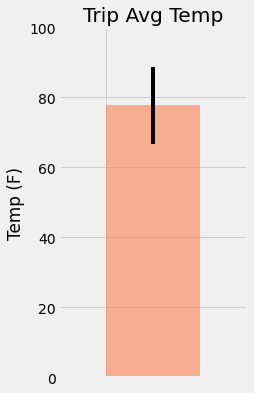

In [84]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error = [df['max']- df['min']]
df.plot(kind='bar', y='avg', yerr=error, color='coral', alpha=0.6,legend = '',
        figsize=(3,6), title='Trip Avg Temp',align='edge')
plt.ylim(0,100)
plt.ylabel("Temp (F)")
plt.tick_params(axis='x', which='both', labelbottom=False)
# Save Figure
plt.savefig("Trip Avg Temp.png")

### Daily Rainfall Average

In [73]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_trip = '2016-08-01'
end_trip = '2016-08-07'

rain_station = (
    session.query(
        Station.station,
        Station.name,
        Station.latitude,
        Station.longitude,
        Station.elevation,
        func.avg(Measurement.prcp),
    )
    .filter(
        Measurement.station == Station.station,
        Measurement.date.between(start_trip, end_trip),
    )
    .group_by(Station.station)
    .order_by(func.avg(Measurement.prcp).desc())
    .all()
)

# Convert query object to data frame
rain_df = pd.DataFrame(np.array(rain_station))
rain_df = rain_df.rename(
    columns={
        0: "Station",
        1: "Location",
        2: "Latitude",
        3: "Longitude",
        4: "Elevation",
        5: "Total Precipitation",
    }
)

rain_df

,Station,Location,Latitude,Longitude,Elevation,Total Precipitation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4,1.5499999999999998
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84888999999998,32.9,0.8599999999999997
2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6,0.5128571428571428
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0,0.3433333333333333
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.18571428571428575
5,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,0.08142857142857143
6,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9,0.045


### Daily Temperature Normals

In [74]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [75]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
date_range = pd.date_range(start_date , end_date)

# Strip off the year and save a list of strings in the format %m-%d
date_list = [d.strftime("%m-%d") for d in date_range]

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
daily_normal = [daily_normals(d)[0] for d in date_list]
print(daily_normal)

[(67.0, 75.54, 83.0), (68.0, 75.60377358490567, 84.0), (70.0, 76.61111111111111, 85.0), (69.0, 76.71153846153847, 84.0), (69.0, 76.14814814814815, 82.0), (67.0, 76.25, 83.0), (71.0, 77.15686274509804, 83.0)]


In [76]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_df = pd.DataFrame(
    daily_normal, columns=["tmin", "tavg", "tmax"], index=date_range
)
normal_df.index.name = "Date"
normal_df

,tmin,tavg,tmax
Date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


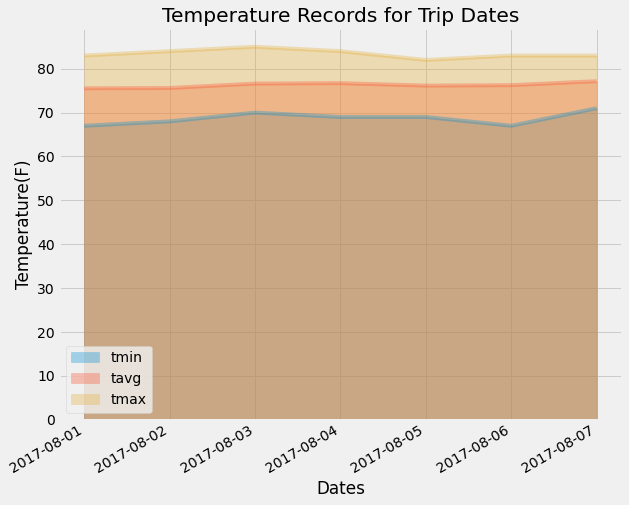

<Figure size 432x288 with 0 Axes>

In [83]:
normal_df.plot(kind="area", stacked=False, x_compat=True, alpha=0.333, figsize=(9, 8))
plt.title(f"Temperature Records for Trip Dates")
plt.xlabel("Dates")
plt.ylabel("Temperature(F)")
plt.show()
# Save Figure
plt.savefig("Temperature_Records.png")

## Close Session